Hello, my name is Artem. I'm going to review your project!

You can find my comments in <font color='green'>green</font>, <font color='blue'>blue</font> or <font color='red'>red</font> boxes like this:

<div class="alert alert-block alert-success">
<b>Success:</b> if everything is done succesfully
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> "Improve" comments mean that there are tiny corrections that could help you to make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

### <font color='orange'>General feedback</font>
* You've worked really hard and submitted a solid project.
* Thank you for structuring the project. It's a pleasure to check such notebooks.
* There are a couple of things that need to be done before your project is complete, but they're pretty straightforward.
* While there's room for improvement, on the whole, your project is looking good.
* I believe you can easily fix it! Good luck!

### <font color='orange'>General feedback (review 2)</font>
* New comments are marked with "review 2" keyword.

### <font color='orange'>General feedback (review 3)</font>
* New comment is marked with "review 3" keyword.

### <font color='orange'>General feedback (review 4)</font>
* New comment is marked with "review 4" keyword.

### <font color='orange'>General feedback (review 5)</font>
* All your hard work has paid off, and now your project is perfect!
* Keep up the good work. Good luck next!

# Zyfra Mining: Machine Learning Analysis

**The objective is to prepare a prototype of a machine learning model to predict the product yield of gold from gold ore. Zyfra develops efficiency solutions for heavy industry.**

In [1]:
#place at the beginning
def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=16)
    ax.set_xlabel(on, fontsize=16)
    return ax 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

<div class="alert alert-block alert-success">
<b>Success:</b> Thank you for collecting all imports in the first cell!
</div>

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

Project description

The data is stored in three files:
gold_recovery_train.csv — training dataset download
gold_recovery_test.csv — test dataset download
gold_recovery_full.csv — source dataset download

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.
Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

The source dataset contains the training and test sets with all the features.
You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, use our instructions.

Data description
Technological process:

Rougher feed — raw material
Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
Xanthate — promoter or flotation activator;
Sulphate — sodium sulphide for this particular process;
Depressant — sodium silicate.
Rougher process — flotation
Rougher tails — product residues
Float banks — flotation unit
Cleaner process — purification
Rougher Au — rougher gold concentrate
Final Au — final gold concentrate
Parameters of stages
air amount — volume of air
fluid levels
feed size — feed particle size
feed rate

Feature naming
Here's how you name the features:
[stage].[parameter_type].[parameter_name]

Example: rougher.input.feed_ag
Possible values for [stage]:
rougher — flotation
primary_cleaner — primary purification
secondary_cleaner — secondary purification
final — final characteristics
Possible values for [parameter_type]:
input — raw material parameters
output — product parameters
state — parameters characterizing the current state of the stage
calculation — calculation characteristics

In [4]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

## Prepare the data

### Download and read the data

In [5]:
df_train = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_train.csv")
df_test = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_test.csv")
df_full = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_full.csv")

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

<div class="alert alert-block alert-success">
<b>Success:</b> Data loading was done well!
</div>

### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

**Reminder of the rougher process**

Rougher feed — raw material Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant Xanthate — promoter or flotation activator; Sulphate — sodium sulphide for this particular process; Depressant — sodium silicate. 

Rougher process — flotation Rougher tails — product residues Float banks — flotation unit Cleaner process — purification Rougher Au — rougher gold concentrate Final Au — final gold concentrate Parameters of stages air amount — volume of air fluid levels feed size — feed particle size feed rate

In [7]:
#filtering for rougher 
list(filter(lambda s:"rougher" in s,df_train.columns))

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

In [8]:
display(df_train['rougher.output.concentrate_au'].head(),
       df_train['rougher.input.feed_au'].head(),
       df_train['rougher.output.tail_au'].head(),
       )

0    19.793808
1    20.050975
2    19.737170
3    19.320810
4    19.216101
Name: rougher.output.concentrate_au, dtype: float64

0    6.486150
1    6.478583
2    6.362222
3    6.118189
4    5.663707
Name: rougher.input.feed_au, dtype: float64

0    1.170244
1    1.184827
2    1.162562
3    1.079755
4    1.012642
Name: rougher.output.tail_au, dtype: float64

In [9]:
#Calculation: train set -- (100 * au__conc_out * au_input - out_tail_au) / ((au_input * au_conc_out) - au_output)

rougher_output_recovery_calc = (100 * (df_train['rougher.output.concentrate_au'] * 
                                      (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])) / 
                                (df_train['rougher.input.feed_au'] * (df_train['rougher.output.concentrate_au'] 
                                                                      - df_train['rougher.output.tail_au'])))

rougher_output_recovery_calc.head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

In [10]:
df_output_rougher = pd.DataFrame({"output_recovery":df_train["rougher.output.recovery"],
                                  "calc":rougher_output_recovery_calc}).dropna()

MAE = mean_absolute_error(df_output_rougher["output_recovery"],df_output_rougher["calc"])

print('MAE =', MAE)
print(df_output_rougher.head())

MAE = 1.0898633667227423e-14
   output_recovery       calc
0        87.107763  87.107763
1        86.843261  86.843261
2        86.842308  86.842308
3        87.226430  87.226430
4        86.688794  86.688794


#### Validating Recovery Output

1) The MAE for the comparison between the calculated and provided recovery values shows that the results are the same

2) The first five rows of both results show how identical the results are 

<div class="alert alert-block alert-success">
<b>Success:</b> This check was done absolutely right!
</div>

### Analyze the features not available in the test set. What are these parameters? What is their type?

In [11]:
#df_types containes all possible parameters and their respective data types
df_types = df_full.dtypes.reset_index() #dtypes display each column and their data types
#reset_index() is to create a new index instead of using the date as the index

df_types.columns = ["name", "type"] #changes column names from 'index' and '0' to 'name' and 'type'

df_types
#86 possible parameters amongst full, train, and test sets

,name,type
0,date,object
1,final.output.concentrate_ag,float64
2,final.output.concentrate_pb,float64
3,final.output.concentrate_sol,float64
4,final.output.concentrate_au,float64
5,final.output.recovery,float64
6,final.output.tail_ag,float64
7,final.output.tail_pb,float64
8,final.output.tail_sol,float64
9,final.output.tail_au,float64


In [12]:
#adding columns for full, train, and test to show count for which parameters are present
df_types['full'] = np.vectorize(lambda x: int(x in df_full.columns))(df_types["name"])
#np.vectorize() -- for convenient iteration
#lambda x: = the lambda arguement
#x in df_full.columns -- the expression that returns an object
#int() -- to express the lambda function as 1 or 0 instead of True or False
#(df_types["name"]) = 'x'

#creating similar columns for train and test
df_types["train"] = np.vectorize(lambda x: int(x in df_train.columns))(df_types["name"].values)
df_types["test"] = np.vectorize(lambda x: int(x in df_test.columns))(df_types["name"].values)
df_types[df_types["test"]==0] #finds all parameters that test is missing

,name,type,full,train,test
1,final.output.concentrate_ag,float64,1,1,0
2,final.output.concentrate_pb,float64,1,1,0
3,final.output.concentrate_sol,float64,1,1,0
4,final.output.concentrate_au,float64,1,1,0
5,final.output.recovery,float64,1,1,0
6,final.output.tail_ag,float64,1,1,0
7,final.output.tail_pb,float64,1,1,0
8,final.output.tail_sol,float64,1,1,0
9,final.output.tail_au,float64,1,1,0
14,primary_cleaner.output.concentrate_ag,float64,1,1,0


#### Conclusion: Missing Features in Test Df

1) There are 68 parameters missing from the test df

2) All 68 were present in both full and train df's

3) All data types were float64

4) The targets are missing from the test dataframe -- these need to be added back in

<div class="alert alert-block alert-success">
<b>Success:</b> Right.
</div>

### Perform Data Preprocessing

1) Targets 'final.output.recovery' and 'rougher.output.recovery' need to be added into train dataframe for target_train variables

2) Are the targets missing values in the dataframes?

In [13]:
#for loop to convert date to datetime -- organizing the dataframes
for df in [df_full, df_train, df_test]:
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True) #date column becomes df index

In [14]:
train_final_null = df_train['final.output.recovery'].isna().sum()
train_rougher_null = df_train['rougher.output.recovery'].isna().sum()
print(train_final_null, train_rougher_null)
#train_targets have missing values

1521 2573


In [15]:
full_final_null = df_full['final.output.recovery'].isna().sum()
full_rougher_null = df_full['rougher.output.recovery'].isna().sum()
print(full_final_null, full_rougher_null)
#test missing values = full missing - train missing

1963 3119


In [16]:
print('test[final.output.recovery] null:', full_final_null - train_final_null)
print('test[rougher.output.recovery] null:', full_rougher_null - train_rougher_null)

test[final.output.recovery] null: 442
test[rougher.output.recovery] null: 546


In [17]:
df_test.shape

(5856, 52)

In [18]:
#Adding target variables to the test df
#ensuring the columns had merged 
df_test = df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery']], 
              how='left', left_index=True, right_index=True)

display(df_test[['final.output.recovery', 'rougher.output.recovery']].head(), df_test.shape)
#merge was successful; test df now has the target variables, 
#test still has missing values carried over from df_full

,final.output.recovery,rougher.output.recovery
date,,
2016-09-01 00:59:59,70.273583,89.993421
2016-09-01 01:59:59,68.910432,88.089657
2016-09-01 02:59:59,68.143213,88.412756
2016-09-01 03:59:59,67.776393,87.360133
2016-09-01 04:59:59,61.467078,83.236367


(5856, 54)

#### Conclusion: Adding The Target Variables Into Test Set
1) Previous pre-merge test df shape was 52 columns, post-merge test df shape is 54 showing that target variables were succesfully added

2) The amount of rows did not change pre and post merge indicating that the values were filled in based on matching indices with the test dataframe, since full has all values including test values

In [19]:
display(df_train.shape, df_test.shape)

(16860, 86)

(5856, 54)

In [20]:
#removing target_train null values
df_train = df_train[~df_train['final.output.recovery'].isna()]
df_train = df_train[~df_train['rougher.output.recovery'].isna()]

#filling in the rest of the df's null values using ffill
df_train = df_train.fillna(method='ffill') #inserts previous series value as null's new value
display(df_train.shape, df_train.isna().sum())


(14149, 86)

final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au                 0
primary_cleaner.output.tail_ag                  

In [21]:
#same process with test set
df_test = df_test[~df_test['final.output.recovery'].isna()]
df_test = df_test[~df_test['rougher.output.recovery'].isna()]
df_test = df_test.fillna(method='ffill')

#### Conclusion: Filling Missing Values

1) The train and test sets had rows with missing target variable values removed

2) The rest of the missing values had values filled in using ffill, which fills the previous row value in for the missing value

<div class="alert alert-block alert-success">
<b>Success:</b> ffill is was the best way ro fill nans in this case!
</div>

## Analyze the data

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

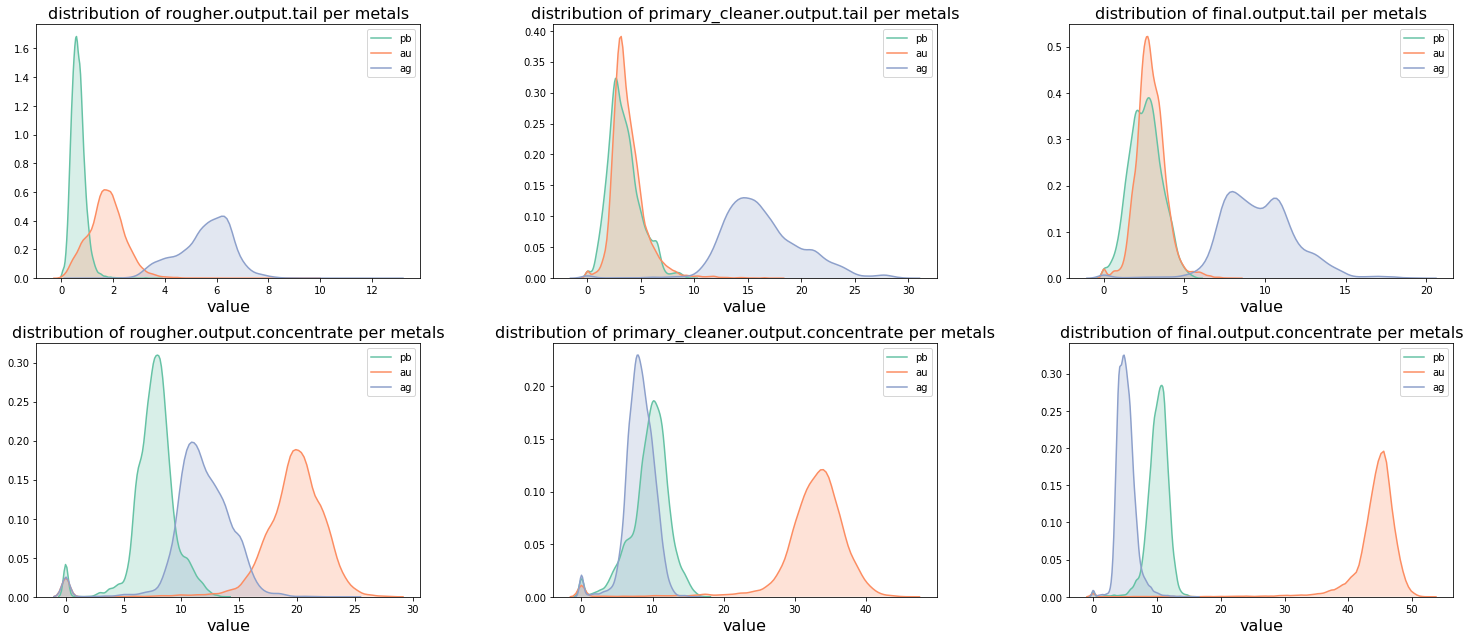

In [22]:
metals = ['au', 'ag', 'pb']
columns = ['rougher.output.tail', 'primary_cleaner.output.tail','final.output.tail',\
           'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

_, axs = plt.subplots(2,3, figsize=(21, 9))
axs = axs.flatten()

for column, ax in zip(columns, axs):
    cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
    temp_df = pd.melt(df_train[cols])
    temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
    display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals", ax=ax)
    ax.legend()

plt.tight_layout()
plt.show()

#### Conclusion: Metal Concentration Changes in Relation to Purification Stage
1) Abnormal concentration values exist in rougher and primary_cleaner stages.

2) Some outliers around 0 exist 

<div class="alert alert-block alert-success">
<b>Success:</b> Great visualization!
</div>

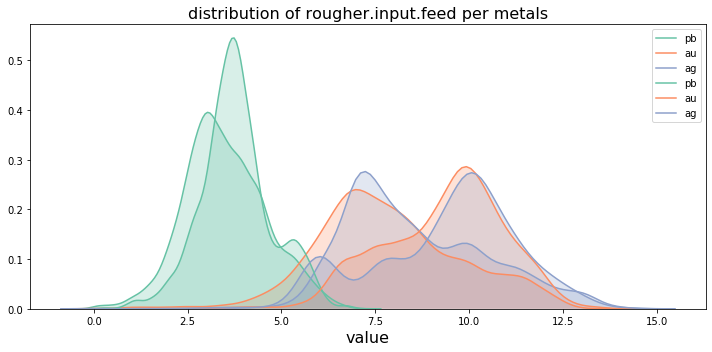

In [23]:
metals = ['au', 'ag', 'pb']
column = 'rougher.input.feed'
cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
temp_df = pd.melt(df_train[cols])
temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
ax = display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals")
temp_df = pd.melt(df_test[cols])
temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals", ax=ax)
plt.tight_layout()
plt.show()

In [24]:
list(filter(lambda s: "feed_size" in s, df_train.columns))

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

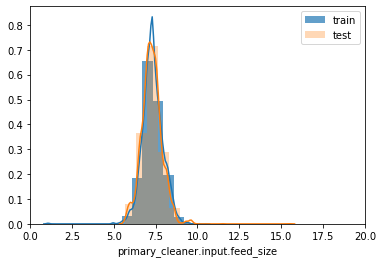

In [25]:
sns.distplot(df_train["primary_cleaner.input.feed_size"],bins=15, hist_kws=dict(alpha=0.7), label="train")
g = sns.distplot(df_test["primary_cleaner.input.feed_size"],bins=15, hist_kws=dict(alpha=0.3), label="test")
g.set(xlim=(0, 20))
g.legend()

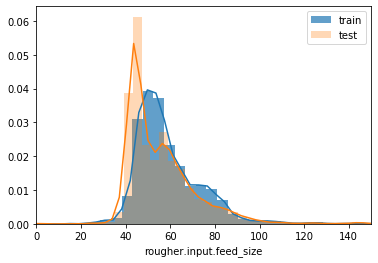

In [26]:
sns.distplot(df_train["rougher.input.feed_size"],bins=100, hist_kws=dict(alpha=0.7), label="train")
g = sns.distplot(df_test["rougher.input.feed_size"],bins=100, hist_kws=dict(alpha=0.3), label="test")
g.set(xlim=(0, 150))
g.legend()

In [27]:
df_train.describe()['rougher.input.feed_size']

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [28]:
df_test.describe()['rougher.input.feed_size']

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

#### Conclusion: Density Plots

1) According to density plots, the feed particle size distributions between training and test sets are different, however, the mean values are close to one another (55 and 60)

2) Concentration of the gold was increased, but lead and silver after the final stage decreased or remained the same. Gold's concentration increases linearly. 

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see that you've used dist plot here.
</div>

## Write a function to calculate the final sMAPE value.

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings. Use these formulas for evaluation metrics:

In [29]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(df_train.columns).intersection(set(df_test.columns)).difference(set(target)))

In [30]:
def smape(y_true, y_pred):
    frac = np.divide(np.abs(y_true - y_pred), (np.abs(y_true)+np.abs(y_pred))/2)
    return np.average(frac, axis=0)

In [31]:
def smape_final(y_true,y_pred):
    smape_out_rougher = smape(y_true[target.index('rougher.output.recovery')], y_pred[target.index('rougher.output.recovery')])
    smape_out_final = smape(y_true[target.index('final.output.recovery')], y_pred[target.index('final.output.recovery')])
    return 0.25*smape_out_rougher + 0.75*smape_out_final

<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've avoid using loops in this function.
</div>

In [32]:
smape_score = make_scorer(smape_final, greater_is_better=False)

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Scorer was defined in the wrong way. Please pay attention to "greater_is_better" parameter.
</div>

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> Well done!
</div>

In [33]:
X_train, X_test = df_train[features].values, df_test[features].values
y_train, y_test = df_train[target].values, df_test[target].values

In [34]:
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_lr.mean())
scores_lr

mean smape: -0.06141021786120606


array([-0.03233747, -0.09156739, -0.09424053, -0.04954844, -0.03935726])

In [35]:
params = {'min_samples_split': range(2, 10, 2), 'max_depth': range(4,8,2)}
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=random_state),param_grid=params,scoring=smape_score, cv=5, refit=True)
g_cv.fit(X_train, y_train)
best_params = g_cv.best_params_

In [36]:
dtr = DecisionTreeRegressor(**best_params).fit(X_train, y_train)
scores_dtr = cross_val_score(dtr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_dtr.mean())
scores_dtr

mean smape: -0.052502635128932884


array([-0.05360794, -0.12016114, -0.01992067, -0.05022054, -0.01860289])

In [37]:
params = {'min_samples_split': range(2, 6, 2)}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=random_state),param_grid=params,scoring=smape_score, cv=5, refit=True)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_

In [38]:
rfr = RandomForestRegressor(**best_params).fit(X_train, y_train)
scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_rfr.mean())
scores_rfr

mean smape: -0.1450034153416387


array([-0.28760231, -0.33727146, -0.02046383, -0.04670262, -0.03297686])

<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've tried several models!
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing (review 2):</b> What about testing? X_test, y_test were not used at all.
</div>

#### sMAPE Metric Evaluation (Train):

1) Linear regression:  𝑠𝑀𝐴𝑃𝐸𝑚𝑒𝑎𝑛≈ -0.0614

2) Decision tree regressor:  𝑠𝑀𝐴𝑃𝐸𝑚𝑒𝑎𝑛≈ -0.0525

3) Random forest regressor:  𝑠𝑀𝐴𝑃𝐸𝑚𝑒𝑎𝑛≈ -0.1399

4) Linear regression and has the lowest sMAPE score, making it best and most accurate trained model

### Final Test

In [53]:
preds_lr = lr.predict(X_test)
smape_lr = -smape_final(y_test, preds_lr) 
#smape_score() doesn't work when using test set, a negative smape_final function is used instead

print("mean smape:", smape_lr)
smape_lr

mean smape: -0.049678811072039177


-0.049678811072039177

<div class="alert alert-block alert-danger">
<b>Needs fixing (review 3):</b> cross_val_score splits data that is passed into train and test set, fit model in train and measure the score on test. In your case it splits X_test to train and test, ...
    
Please just train model on X_train and predict on X_test without cross_val_score.
</div>

<div class="alert alert-block alert-danger">

<b>Needs fixing (review 4):</b> There is a typo: `scores_lr` was used instead of `smape_lr`. `.mean()` shouldn't be use because `smape_final` returns one value.
</div>

#### Final Test Results

1) The final test yielded a mean smape score of -0.05

2) The cross-valid score -0.06 was slightly better, but -0.05 is not too much different

3) The model is still adequate

## General Conclusion

1) An accurate prototype model in predicting gold yields may now be used by Zyfra.

2) Since it is only a prototype, implementation can be used but is still subject for improvement before a final model is officially released.